# 数据导入和预处理部分



In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import argparse
from torchvision.models import resnet50, ResNet50_Weights
import re
import matplotlib.pyplot as plt

# 设置随机种子以保证结果可复现
torch.manual_seed(56)
np.random.seed(56)

# 加载预训练的BERT模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
pretrained_model = BertModel.from_pretrained("bert-base-multilingual-cased")

max_length = 50  # 输入的最大文本长度
num_classes = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_path = "/kaggle/input/lab5-data/data/"

# 图像数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小
    transforms.ToTensor(),         # 将图像转换为 Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 归一化
])


# 读取文本文件，处理编码问题
def get_texts_from_textsPath(folder_path, df):
    texts = []
    for ind in df['guid']:
        file = folder_path + str(ind) + ".txt"
        try:
            with open(file, "r", encoding="GB18030") as infile:
                content = infile.read()
        except UnicodeDecodeError:
            print(f"Failed to decode file: {file}")
            continue                
        texts.append(content)
    return texts


# 清洗文本
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # 去除非字母和数字字符
    # text = re.sub(r"\s+", " ", text).strip()  # 去除多余空格
    return text


# 文本预处理
def text_preprocess(texts):
    cleaned_texts = [clean_text(text) for text in texts]
    tokenized_texts = [
        tokenizer(text, padding='max_length', max_length=max_length, truncation=True, return_tensors="pt") for text in
        cleaned_texts]
    return tokenized_texts


# 图片和文本混合数据集
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, tokenized_texts, labels, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.input_ids = [x['input_ids'].squeeze(0) for x in tokenized_texts]
        self.attention_mask = [x['attention_mask'].squeeze(0) for x in tokenized_texts]
        self.labels = labels

    def __getitem__(self, index):
        input_ids = self.input_ids[index]
        attention_mask = self.attention_mask[index]
        labels = torch.tensor(self.labels[index])
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        image = self.transform(image)
        return image, input_ids, attention_mask, labels

    def __len__(self):
        return len(self.input_ids)


# 依据train.txt获取训练集图片路径列表
def get_valid_imagesPath_from_directory(folder_path, df):
    image_paths = []
    for ind in df['guid']:
        image_path = folder_path + str(ind) + ".jpg"
        try:
            image = cv2.imread(image_path)
            height, width, channels = image.shape
            image_paths.append(image_path)
        except Exception as e:
            print(f"File '{image_path}' not found or invalid: {e}")
            continue
    return image_paths


# 数据准备
train_label_path = "/kaggle/input/lab5-data/train.txt"
train_label_df = pd.read_csv(train_label_path, sep=",")
column_dict = {"positive": 0, "negative": 1, "neutral": 2}
# 使用 np.vectorize 替换 'tag' 列的值
replace_func = np.vectorize(lambda x: column_dict.get(x, x))
new_df = train_label_df.copy()  # 创建副本以避免修改原始 DataFrame
new_df['tag'] = replace_func(new_df['tag'])
labels = list(new_df['tag'])

image_paths = get_valid_imagesPath_from_directory(folder_path, new_df)
texts = get_texts_from_textsPath(folder_path, new_df)

# 划分验证集
image_paths_train, image_paths_val, texts_train, texts_val, labels_train, labels_val = train_test_split(
    image_paths, texts, labels, test_size=0.2, random_state=5)

# 文本预处理
tokenized_texts_train = text_preprocess(texts_train)
tokenized_texts_val = text_preprocess(texts_val)

# 构建Dataset
dataset_train = Dataset(image_paths_train, tokenized_texts_train, labels_train, transform)
dataset_val = Dataset(image_paths_val, tokenized_texts_val, labels_val, transform)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

# 定义多模态模型，其中option用于后续消融实验对比

In [2]:
# 图片特征提取模型定义
class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImageFeatureExtractor, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  # 使用预训练的ResNet-50作为图片特征提取器
        self.norm = nn.LayerNorm(1000)  # 归一化层

    def forward(self, image):
        features = self.resnet(image)
        return features


# 文本特征提取模型定义
class TextFeatureExtractor(nn.Module):
    def __init__(self):
        super(TextFeatureExtractor, self).__init__()
        self.bert = pretrained_model
        for param in self.bert.parameters():
            param.requires_grad = False  # 冻结 BERT 权重
        self.norm = nn.LayerNorm(768)  # 归一化层

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output   # 获取池化后的特征 [batch_size, 768]
        return pooled_output

class CrossModalAttention(nn.Module):
    """
    交叉模态注意力模块
    """
    def __init__(self, image_dim, text_dim, hidden_dim):
        super(CrossModalAttention, self).__init__()
        self.query = nn.Linear(image_dim, hidden_dim)
        self.key = nn.Linear(text_dim, hidden_dim)
        self.value = nn.Linear(text_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, image_features, text_features):
        Q = self.query(image_features)  # 图像特征的查询向量
        K = self.key(text_features)     # 文本特征的键向量
        V = self.value(text_features)   # 文本特征的值向量

        # 计算注意力分数
        attention_scores = torch.matmul(Q, K.T) / np.sqrt(K.shape[-1])
        attention_weights = self.softmax(attention_scores)

        # 加权求和
        attended_text_features = torch.matmul(attention_weights, V)
        return attended_text_features


# 多模态融合模型定义
class FusionModel(nn.Module):
    def __init__(self, num_classes, option, hidden_dim=256):
        super(FusionModel, self).__init__()
        self.image_extractor = ImageFeatureExtractor()
        self.text_encoder = TextFeatureExtractor()
        self.option = option

        # 交叉模态注意力模块
        self.cross_modal_attention = CrossModalAttention(image_dim=1000, text_dim=768, hidden_dim=hidden_dim)

        # 分类器
        self.classifier0 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1000, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, num_classes)
        )

        self.classifier1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(768, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, num_classes)
        )

        self.classifier2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1000 + 768 + 256, hidden_dim * 2),  # 融合后的特征维度
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim * 2, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        if self.option == 0:
            image_features = self.image_extractor(image)
            output = self.classifier0(image_features)
        elif self.option == 1:
            text_features = self.text_encoder(input_ids, attention_mask)
            output = self.classifier1(text_features)
        else:
            image_features = self.image_extractor(image)
            text_features = self.text_encoder(input_ids, attention_mask)

            # 使用交叉模态注意力
            attended_text_features = self.cross_modal_attention(image_features, text_features)

            # 融合特征
            fusion_features = torch.cat((image_features, text_features, attended_text_features), dim=-1)
            output = self.classifier2(fusion_features)
        return output


# 训练过程
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    total_correct = 0
    batch_losses = []  # 用于存储每个 batch 的损失值
    
    for batch_idx, (images, input_ids, attention_mask, labels) in enumerate(train_loader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # 将当前 batch 的损失值存储到列表中
        batch_losses.append(loss.item())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = total_correct.item() / len(train_loader.dataset)

    return epoch_loss, epoch_acc, batch_losses


# 验证过程
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0
    total_correct = 0
    with torch.no_grad():
        for images, input_ids, attention_mask, labels in val_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels)
    val_loss = running_loss / len(val_loader)
    val_acc = total_correct.item() / len(val_loader.dataset)
    return val_loss, val_acc


# 预测过程
def predict_model(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, input_ids, attention_mask, _ in test_loader:
            images = images.to(device)
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# 为每个学习率绘制loss曲线
def plot_loss_curve(train_losses, val_losses, lr):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Train Loss (LR: {lr})')
    plt.plot(val_losses, label=f'Validation Loss (LR: {lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss Curves (LR: {lr})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'loss_curve_lr_{lr}.png')  # 保存为不同文件
    plt.show()

def plot_accuracy_curve(train_accs, val_accs, lr):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label=f'Train Accuracy (LR: {lr})')
    plt.plot(val_accs, label=f'Validation Accuracy (LR: {lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy Curves (LR: {lr})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'accuracy_curve_lr_{lr}.png')  # 保存为不同文件
    plt.show()


# 定义统一的绘图函数，对比不同的lr
def plot_combined_loss_curves(all_train_losses, all_val_losses, lrs):
    plt.figure(figsize=(10, 5))
    for lr, train_losses, val_losses in zip(lrs, all_train_losses, all_val_losses):
        plt.plot(train_losses, label=f'Train Loss (LR: {lr})')
        plt.plot(val_losses, label=f'Validation Loss (LR: {lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Combined Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.savefig('combined_loss_curve.png')  # 保存为统一文件
    plt.show()

# 定义统一的准确率绘图函数
def plot_combined_accuracy_curves(all_train_accs, all_val_accs, lrs):
    plt.figure(figsize=(10, 5))
    for lr, train_accs, val_accs in zip(lrs, all_train_accs, all_val_accs):
        plt.plot(train_accs, label=f'Train Accuracy (LR: {lr})')
        plt.plot(val_accs, label=f'Validation Accuracy (LR: {lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Combined Training and Validation Accuracy Curves')
    plt.legend()
    plt.grid(True)
    plt.savefig('combined_accuracy_curve.png')  # 保存为统一文件
    plt.show()


# 比较不同的学习率对模型的影响

Start training using fusion model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s] 


Batch size: 64, LR: 0.001, Epoch 1/6, Train Loss: 1.0266, Train Acc: 0.5625, Val Loss: 0.9168, Val Acc: 0.5962, Best Val Acc: 0.5962
Batch size: 64, LR: 0.001, Epoch 2/6, Train Loss: 0.9138, Train Acc: 0.5878, Val Loss: 0.9294, Val Acc: 0.5962, Best Val Acc: 0.5962
Batch size: 64, LR: 0.001, Epoch 3/6, Train Loss: 0.8840, Train Acc: 0.5972, Val Loss: 0.8875, Val Acc: 0.5962, Best Val Acc: 0.5962
Batch size: 64, LR: 0.001, Epoch 4/6, Train Loss: 0.8704, Train Acc: 0.5962, Val Loss: 0.8867, Val Acc: 0.5962, Best Val Acc: 0.5962
Batch size: 64, LR: 0.001, Epoch 5/6, Train Loss: 0.8583, Train Acc: 0.5981, Val Loss: 0.8885, Val Acc: 0.5962, Best Val Acc: 0.5962
Batch size: 64, LR: 0.001, Epoch 6/6, Train Loss: 0.8616, Train Acc: 0.5966, Val Loss: 0.8870, Val Acc: 0.5962, Best Val Acc: 0.5962


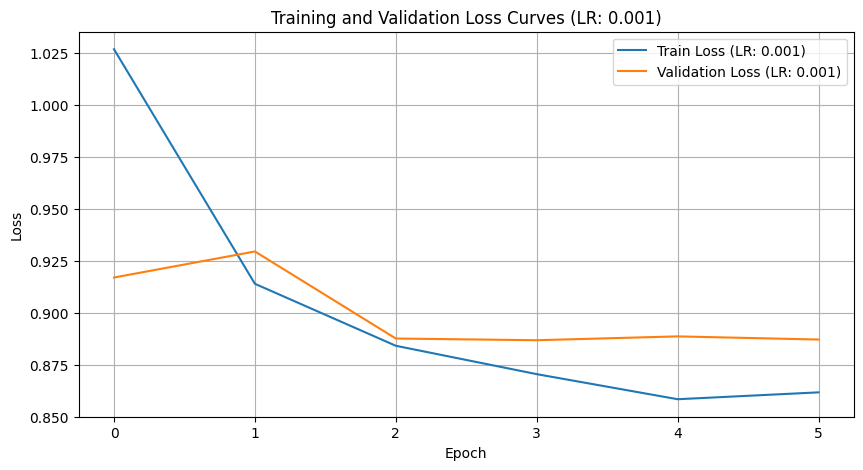

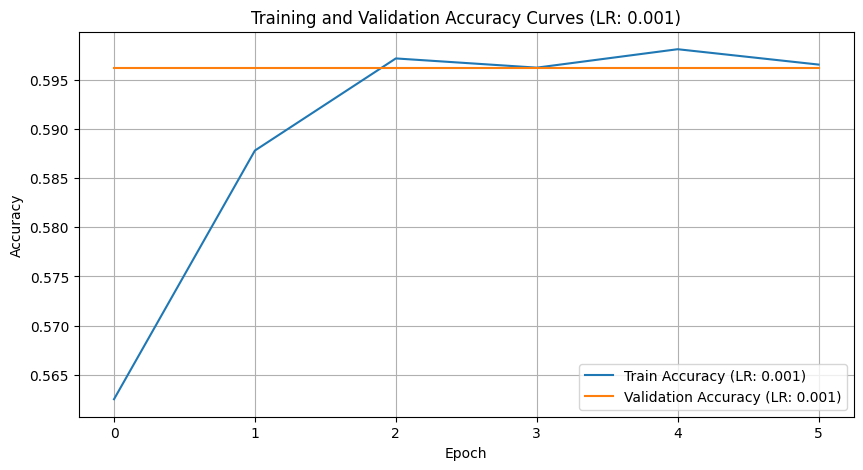

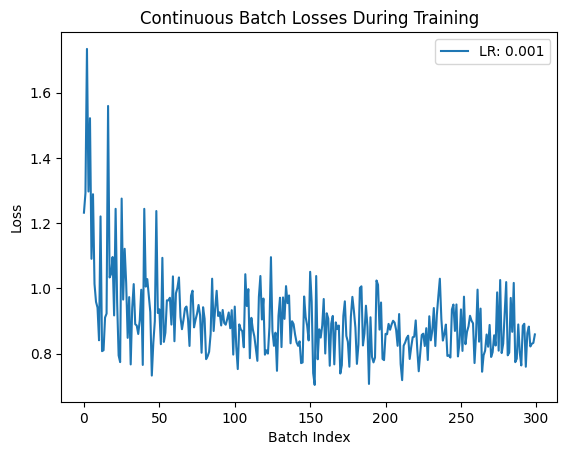

Batch size: 64, LR: 0.0001, Epoch 1/6, Train Loss: 0.8993, Train Acc: 0.5925, Val Loss: 0.8355, Val Acc: 0.6312, Best Val Acc: 0.6312
Batch size: 64, LR: 0.0001, Epoch 2/6, Train Loss: 0.5835, Train Acc: 0.7528, Val Loss: 1.0095, Val Acc: 0.6062, Best Val Acc: 0.6312
Batch size: 64, LR: 0.0001, Epoch 3/6, Train Loss: 0.2707, Train Acc: 0.9113, Val Loss: 0.9747, Val Acc: 0.6112, Best Val Acc: 0.6312
Batch size: 64, LR: 0.0001, Epoch 4/6, Train Loss: 0.1750, Train Acc: 0.9509, Val Loss: 1.0860, Val Acc: 0.6300, Best Val Acc: 0.6312
Batch size: 64, LR: 0.0001, Epoch 5/6, Train Loss: 0.1170, Train Acc: 0.9753, Val Loss: 1.0891, Val Acc: 0.6275, Best Val Acc: 0.6312
Batch size: 64, LR: 0.0001, Epoch 6/6, Train Loss: 0.1109, Train Acc: 0.9744, Val Loss: 1.0967, Val Acc: 0.6250, Best Val Acc: 0.6312


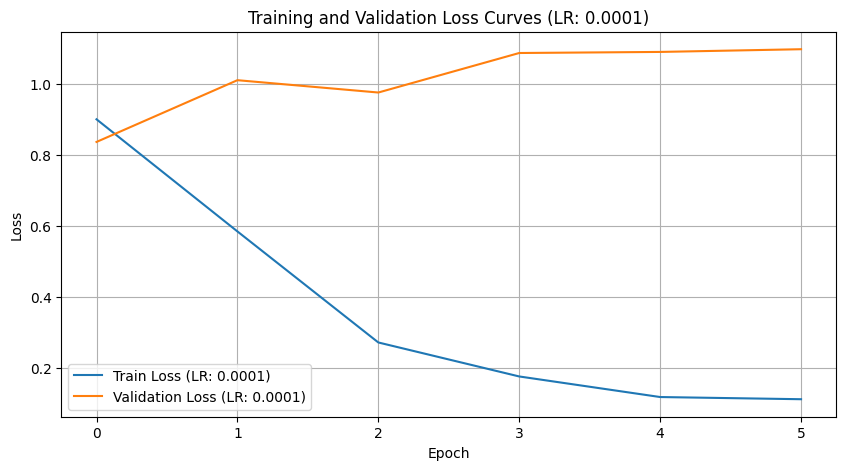

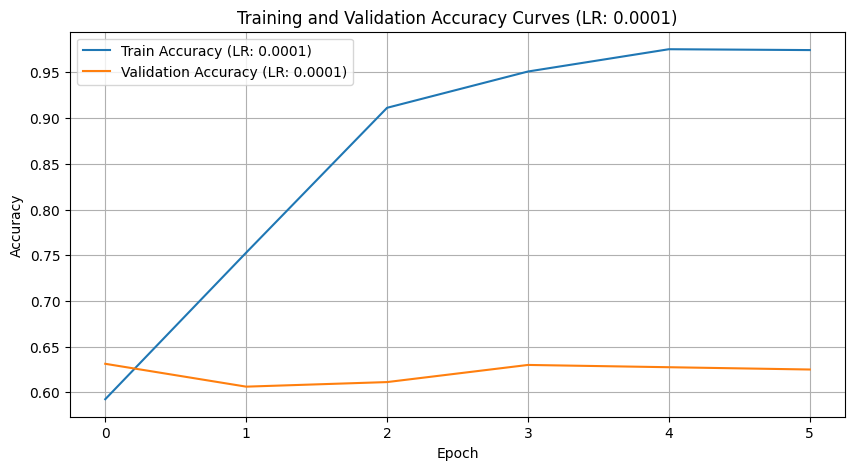

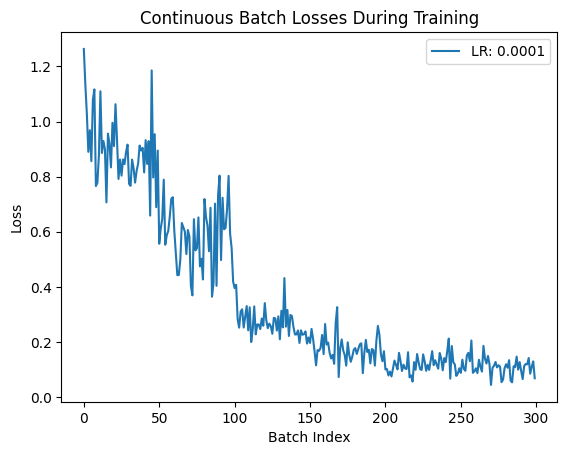

Batch size: 64, LR: 1e-05, Epoch 1/6, Train Loss: 1.0039, Train Acc: 0.5344, Val Loss: 0.8633, Val Acc: 0.6038, Best Val Acc: 0.6038
Batch size: 64, LR: 1e-05, Epoch 2/6, Train Loss: 0.8802, Train Acc: 0.5984, Val Loss: 0.8329, Val Acc: 0.6262, Best Val Acc: 0.6262
Batch size: 64, LR: 1e-05, Epoch 3/6, Train Loss: 0.8353, Train Acc: 0.6128, Val Loss: 0.8283, Val Acc: 0.6300, Best Val Acc: 0.6300
Batch size: 64, LR: 1e-05, Epoch 4/6, Train Loss: 0.8123, Train Acc: 0.6256, Val Loss: 0.8261, Val Acc: 0.6338, Best Val Acc: 0.6338
Batch size: 64, LR: 1e-05, Epoch 5/6, Train Loss: 0.8223, Train Acc: 0.6291, Val Loss: 0.8265, Val Acc: 0.6312, Best Val Acc: 0.6338
Batch size: 64, LR: 1e-05, Epoch 6/6, Train Loss: 0.8316, Train Acc: 0.6222, Val Loss: 0.8265, Val Acc: 0.6338, Best Val Acc: 0.6338


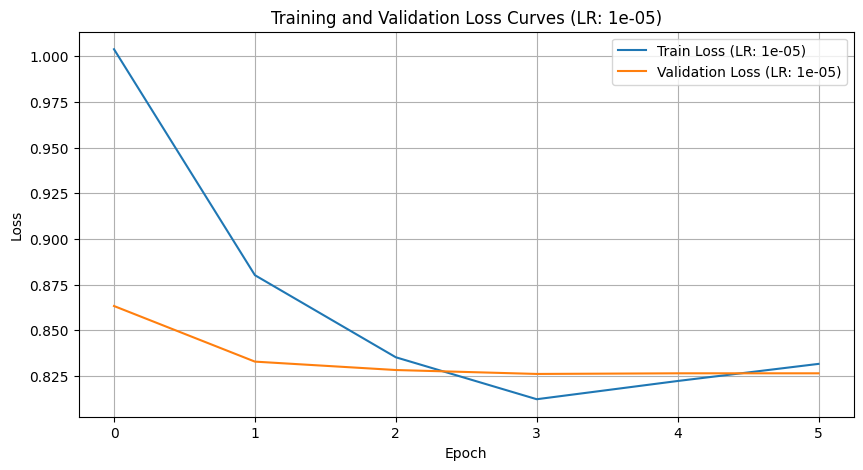

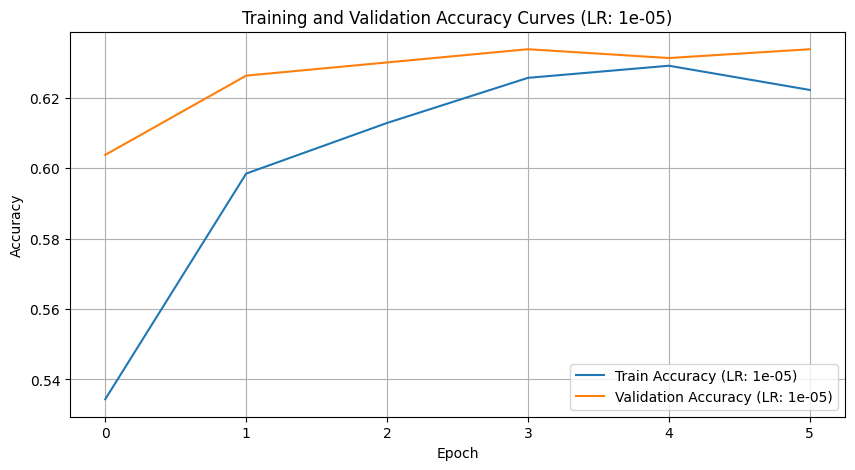

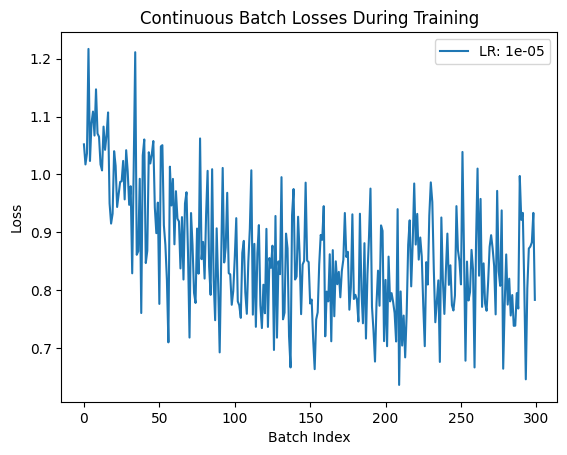

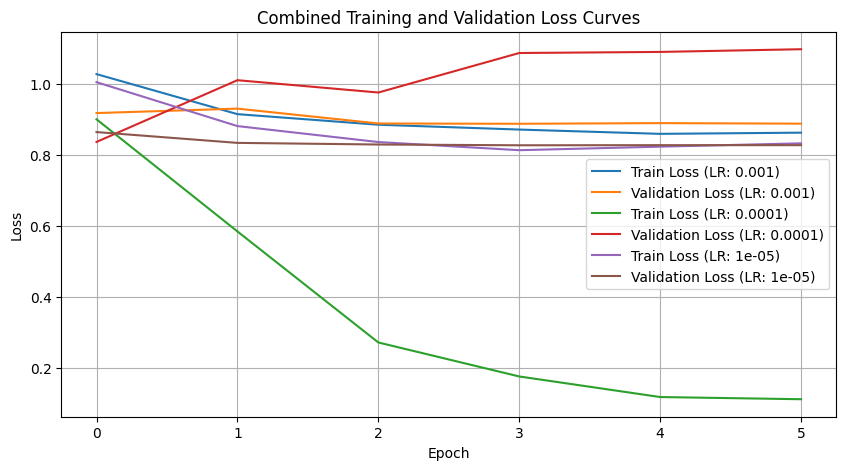

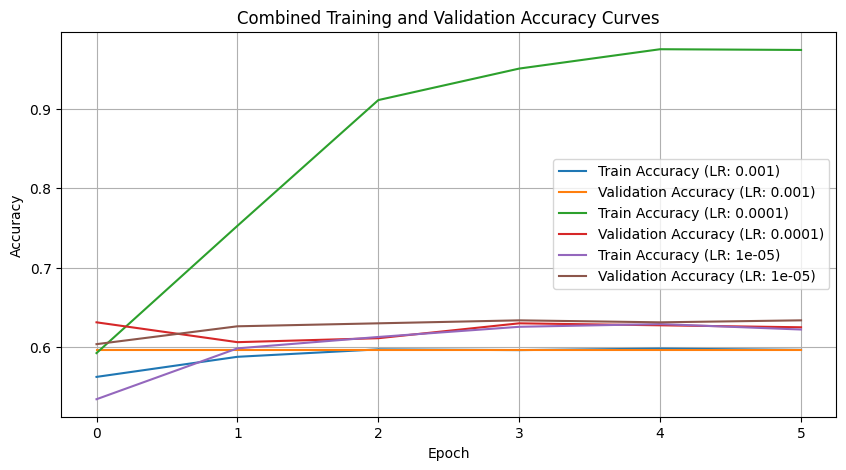

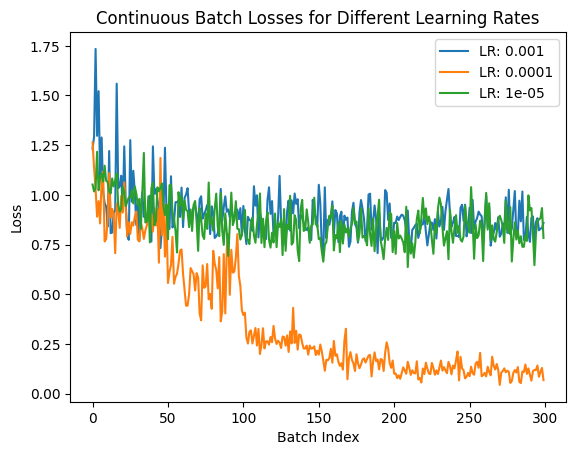

Training finished


In [3]:
# 模型训练和验证
torch.cuda.set_device(0)
criterion = nn.CrossEntropyLoss()
lrs = [1e-3, 1e-4, 1e-5]
batch_size = 64
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
option = 2


if option == 0:
    print("Start training only using image...")
elif option == 1:
    print("Start training only using text...")
elif option == 2:
    print("Start training using fusion model...")


# 用于存储所有学习率的损失和准确率
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
all_batch_losses_list = []  # 用于存储每个学习率的 all_batch_losses

for lr in lrs:
    # 用于记录训练和验证的损失和准确率
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    all_batch_losses = []  # 用于记录所有 epoch 的连续的 batch_losses
    best_acc = 0
    
    model = FusionModel(num_classes, option)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    num_epochs = 6
    
    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses= train_model(model, loader_train, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model, loader_val, criterion, device)

        # 记录损失和准确率
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 将当前 epoch 的 batch_losses 追加到 all_batch_losses 中
        all_batch_losses.extend(batch_losses)  # 使用 extend 将 batch_losses 追加到连续列表中
        
        if val_acc > best_acc:
            best_acc = val_acc
            # torch.save(model.state_dict(), 'multi_model.pt')

        print(f"Batch size: {batch_size}, LR: {lr}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Best Val Acc: {best_acc:.4f}")
        scheduler.step()
        
    # 调用绘图函数
    plot_loss_curve(train_losses, val_losses, lr)
    plot_accuracy_curve(train_accs, val_accs, lr)
    # 绘制所有 epoch 的 batch_losses 连续变化
    plt.plot(all_batch_losses, label=f"LR: {lr}")
    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title("Continuous Batch Losses During Training")
    plt.legend()
    plt.show()

    # 将当前学习率的 all_batch_losses 添加到全局列表中
    all_batch_losses_list.append(all_batch_losses)
    
    # 将当前学习率的损失和准确率存储起来
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)


# 在循环结束后调用统一绘图函数
plot_combined_loss_curves(all_train_losses, all_val_losses, lrs)
plot_combined_accuracy_curves(all_train_accs, all_val_accs, lrs)

for lr, all_batch_losses in zip(lrs, all_batch_losses_list):
    plt.plot(all_batch_losses, label=f"LR: {lr}")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Continuous Batch Losses for Different Learning Rates")
plt.legend()
plt.show()

print("Training finished")

# 不使用正则化强度weight_decay,lr=1e-4的消融实验对比

Start training only using image...
Option: 0, Epoch 1/20, Train Loss: 0.9138, Train Acc: 0.5966, Val Loss: 0.8130, Val Acc: 0.6450, Best Val Acc: 0.6450
Option: 0, Epoch 2/20, Train Loss: 0.6718, Train Acc: 0.7044, Val Loss: 0.8922, Val Acc: 0.6438, Best Val Acc: 0.6450
Option: 0, Epoch 3/20, Train Loss: 0.3670, Train Acc: 0.8675, Val Loss: 0.8452, Val Acc: 0.6400, Best Val Acc: 0.6450
Option: 0, Epoch 4/20, Train Loss: 0.2714, Train Acc: 0.9150, Val Loss: 0.9110, Val Acc: 0.6425, Best Val Acc: 0.6450
Option: 0, Epoch 5/20, Train Loss: 0.2205, Train Acc: 0.9344, Val Loss: 0.9183, Val Acc: 0.6412, Best Val Acc: 0.6450
Option: 0, Epoch 6/20, Train Loss: 0.2097, Train Acc: 0.9409, Val Loss: 0.9240, Val Acc: 0.6400, Best Val Acc: 0.6450
Early stopping triggered after 6 epochs.
Start training only using text...
Option: 1, Epoch 1/20, Train Loss: 0.9593, Train Acc: 0.5691, Val Loss: 0.9256, Val Acc: 0.5962, Best Val Acc: 0.5962
Option: 1, Epoch 2/20, Train Loss: 0.9277, Train Acc: 0.5944, Va

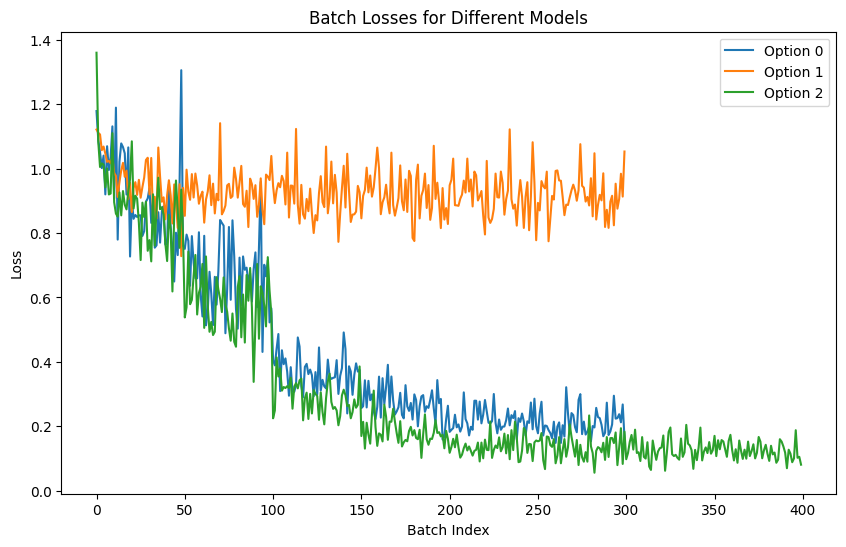

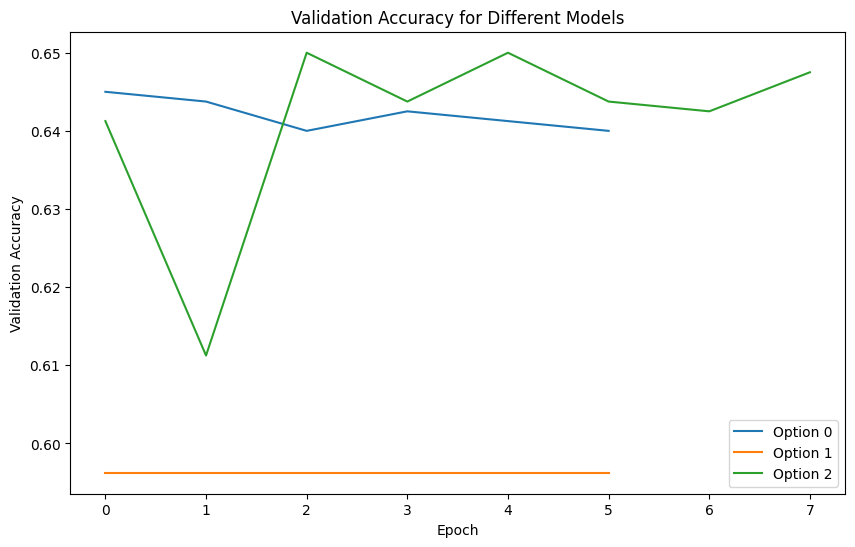

In [4]:
torch.cuda.set_device(0)
criterion = nn.CrossEntropyLoss()
lr = 1e-4
batch_size = 64
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
options = [0, 1, 2]

# 用于存储所有模型的损失和准确率
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
all_batch_losses = []  # 用于记录每个模型的所有 batch loss

# 消融实验
for option in options:
    if option == 0:
        print("Start training only using image...")
    elif option == 1:
        print("Start training only using text...")
    elif option == 2:
        print("Start training using fusion model...")

    # 用于记录训练和验证的损失和准确率
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    all_batch_loss = []  # 用于记录当前模型的所有 batch loss
    best_acc = 0
    early_stopping_patience = 5
    epochs_no_improve = 0

    model = FusionModel(num_classes, option)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    num_epochs = 20

    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses = train_model(model, loader_train, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model, loader_val, criterion, device)

        # 记录损失和准确率
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 将当前 epoch 的 batch loss 追加到 all_batch_loss 中
        all_batch_loss.extend(batch_losses)

        if val_acc > best_acc:
            best_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f"Option: {option}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Best Val Acc: {best_acc:.4f}")

        # 检查是否触发早停
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        scheduler.step()

    # 保存模型状态
    torch.save(model.state_dict(), f'multi_model_option_{option}.pt')

    # 将当前模型的损失和准确率存储到全局列表中
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)
    all_batch_losses.append(all_batch_loss)

print("Training finished")

# 绘制所有模型的 batch loss 曲线
plt.figure(figsize=(10, 6))
for option, batch_loss in enumerate(all_batch_losses):
    plt.plot(batch_loss, label=f"Option {option}")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Batch Losses for Different Models")
plt.legend()
plt.show()

# 绘制所有模型的验证准确率曲线
plt.figure(figsize=(10, 6))
for option, val_acc in enumerate(all_val_accs):
    plt.plot(val_acc, label=f"Option {option}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different Models")
plt.legend()
plt.show()

# 采用正则化强度为1e-5，对比不同学习率的影响

Start training using fusion model...
Batch size: 64, LR: 0.001, Epoch 1/6, Train Loss: 1.0450, Train Acc: 0.5641, Val Loss: 1.8670, Val Acc: 0.5962, Best Val Acc: 0.5962
Batch size: 64, LR: 0.001, Epoch 2/6, Train Loss: 0.9296, Train Acc: 0.5866, Val Loss: 0.9207, Val Acc: 0.5962, Best Val Acc: 0.5962
Batch size: 64, LR: 0.001, Epoch 3/6, Train Loss: 0.8811, Train Acc: 0.5956, Val Loss: 0.8884, Val Acc: 0.6138, Best Val Acc: 0.6138
Batch size: 64, LR: 0.001, Epoch 4/6, Train Loss: 0.8616, Train Acc: 0.5969, Val Loss: 0.8719, Val Acc: 0.6162, Best Val Acc: 0.6162
Batch size: 64, LR: 0.001, Epoch 5/6, Train Loss: 0.8444, Train Acc: 0.6131, Val Loss: 0.8735, Val Acc: 0.6200, Best Val Acc: 0.6200
Batch size: 64, LR: 0.001, Epoch 6/6, Train Loss: 0.8484, Train Acc: 0.6166, Val Loss: 0.8727, Val Acc: 0.6238, Best Val Acc: 0.6238


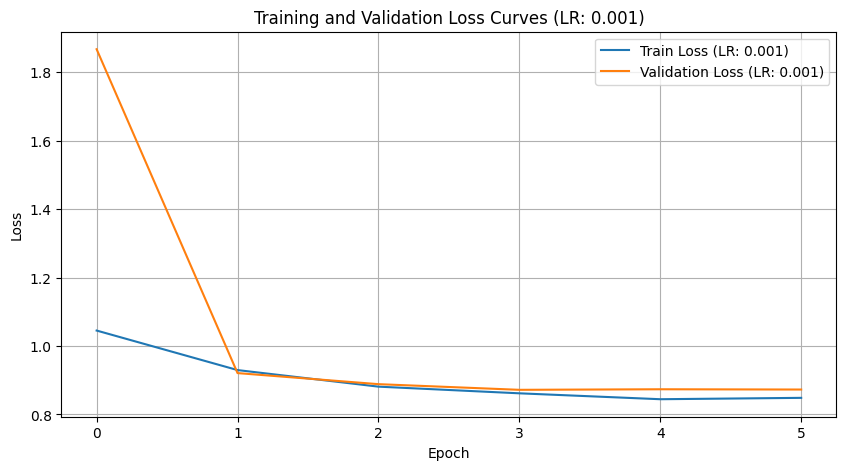

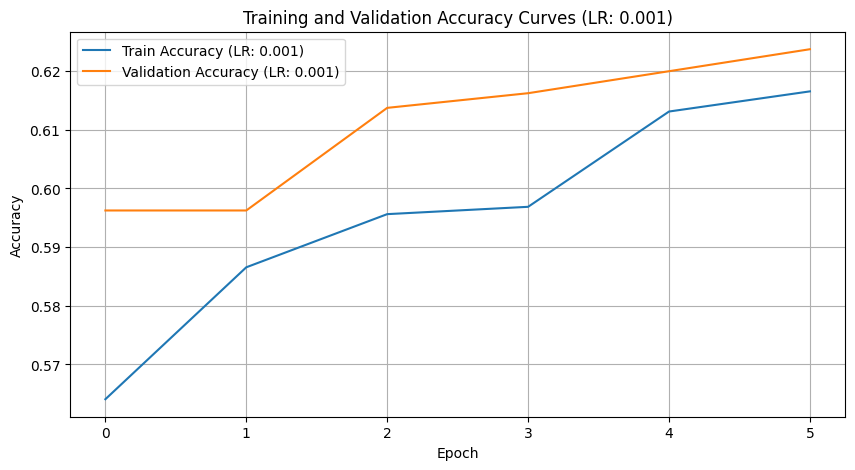

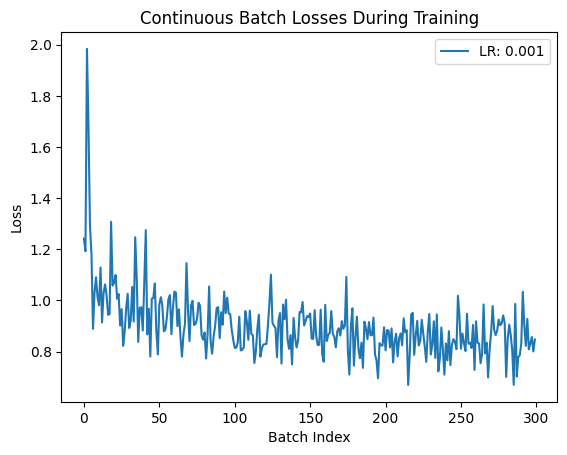

Batch size: 64, LR: 0.0001, Epoch 1/6, Train Loss: 0.8857, Train Acc: 0.6009, Val Loss: 0.8287, Val Acc: 0.6575, Best Val Acc: 0.6575
Batch size: 64, LR: 0.0001, Epoch 2/6, Train Loss: 0.5926, Train Acc: 0.7466, Val Loss: 0.9401, Val Acc: 0.6350, Best Val Acc: 0.6575
Batch size: 64, LR: 0.0001, Epoch 3/6, Train Loss: 0.2759, Train Acc: 0.9144, Val Loss: 0.8736, Val Acc: 0.6375, Best Val Acc: 0.6575
Batch size: 64, LR: 0.0001, Epoch 4/6, Train Loss: 0.1817, Train Acc: 0.9525, Val Loss: 0.9741, Val Acc: 0.6338, Best Val Acc: 0.6575
Batch size: 64, LR: 0.0001, Epoch 5/6, Train Loss: 0.1332, Train Acc: 0.9731, Val Loss: 0.9804, Val Acc: 0.6350, Best Val Acc: 0.6575
Batch size: 64, LR: 0.0001, Epoch 6/6, Train Loss: 0.1295, Train Acc: 0.9672, Val Loss: 0.9844, Val Acc: 0.6400, Best Val Acc: 0.6575


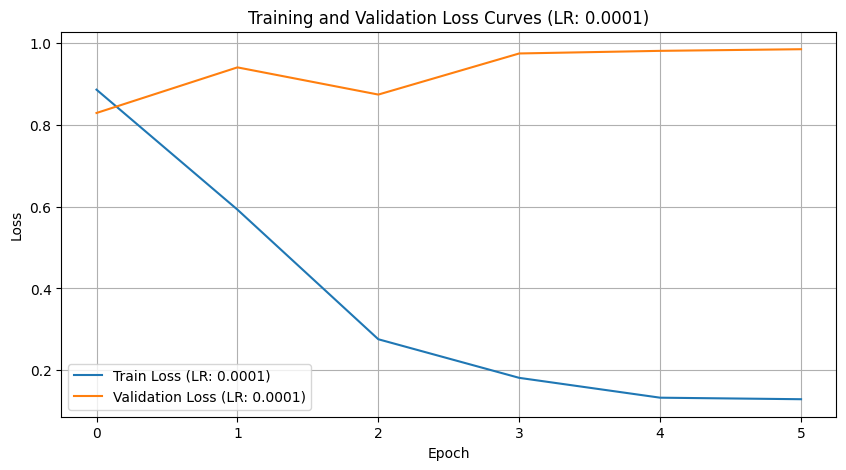

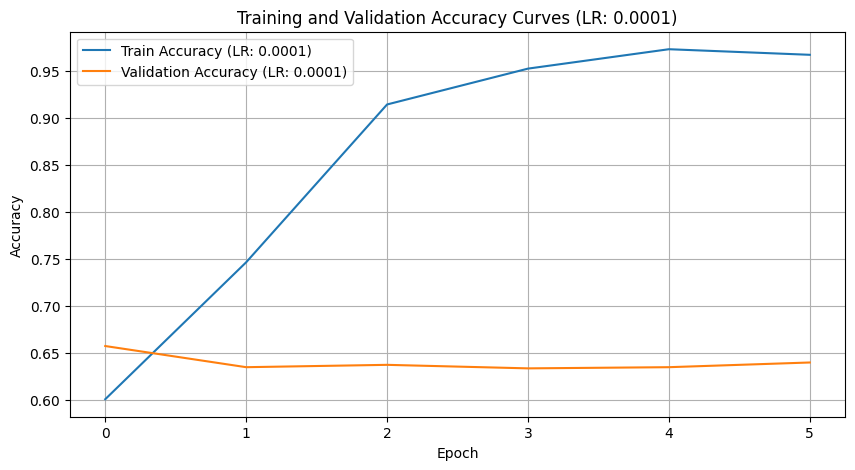

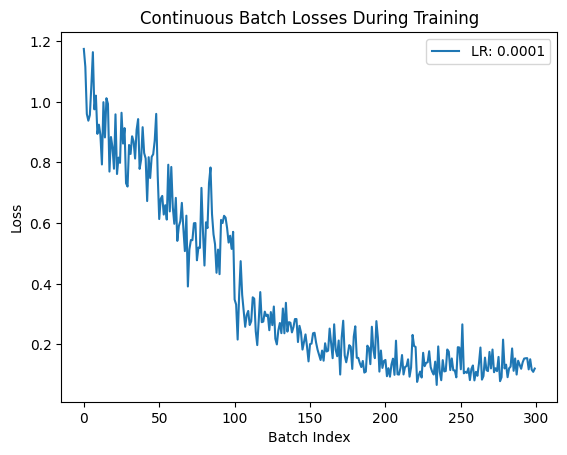

Batch size: 64, LR: 1e-05, Epoch 1/6, Train Loss: 1.0297, Train Acc: 0.5003, Val Loss: 0.8910, Val Acc: 0.6062, Best Val Acc: 0.6062
Batch size: 64, LR: 1e-05, Epoch 2/6, Train Loss: 0.8942, Train Acc: 0.6000, Val Loss: 0.8480, Val Acc: 0.6150, Best Val Acc: 0.6150
Batch size: 64, LR: 1e-05, Epoch 3/6, Train Loss: 0.8449, Train Acc: 0.6125, Val Loss: 0.8427, Val Acc: 0.6175, Best Val Acc: 0.6175
Batch size: 64, LR: 1e-05, Epoch 4/6, Train Loss: 0.8438, Train Acc: 0.6238, Val Loss: 0.8397, Val Acc: 0.6200, Best Val Acc: 0.6200
Batch size: 64, LR: 1e-05, Epoch 5/6, Train Loss: 0.8273, Train Acc: 0.6266, Val Loss: 0.8407, Val Acc: 0.6150, Best Val Acc: 0.6200
Batch size: 64, LR: 1e-05, Epoch 6/6, Train Loss: 0.8329, Train Acc: 0.6262, Val Loss: 0.8409, Val Acc: 0.6175, Best Val Acc: 0.6200


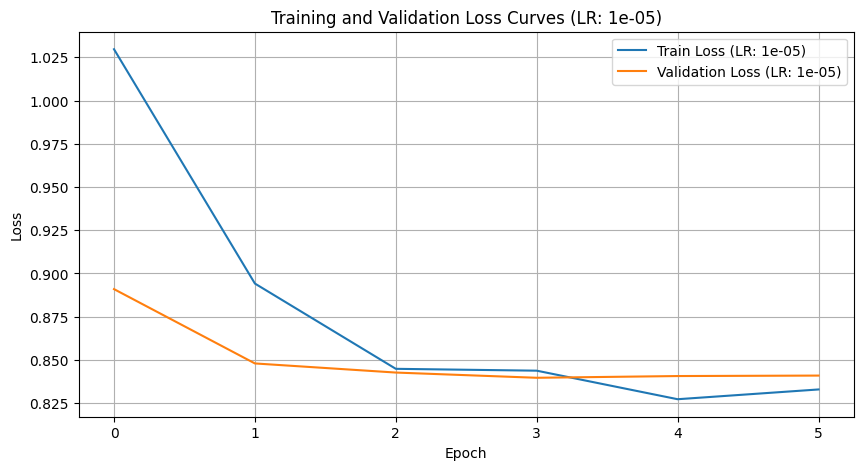

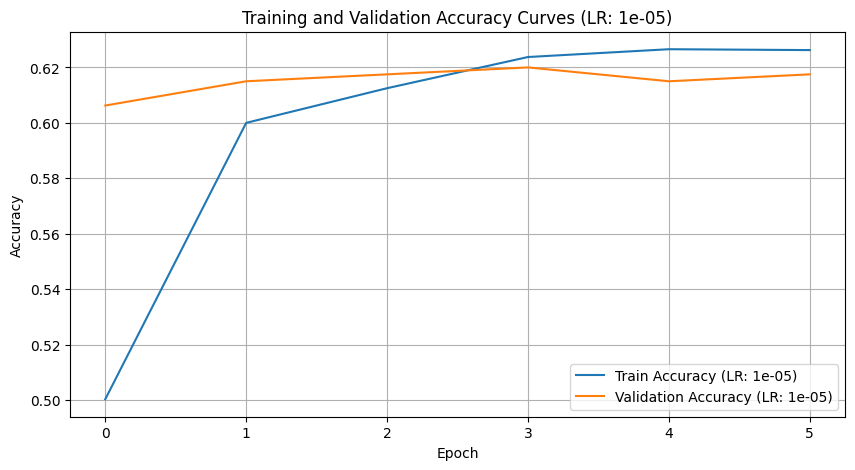

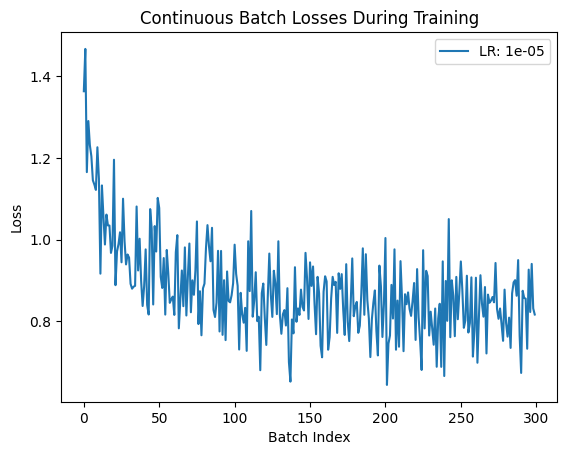

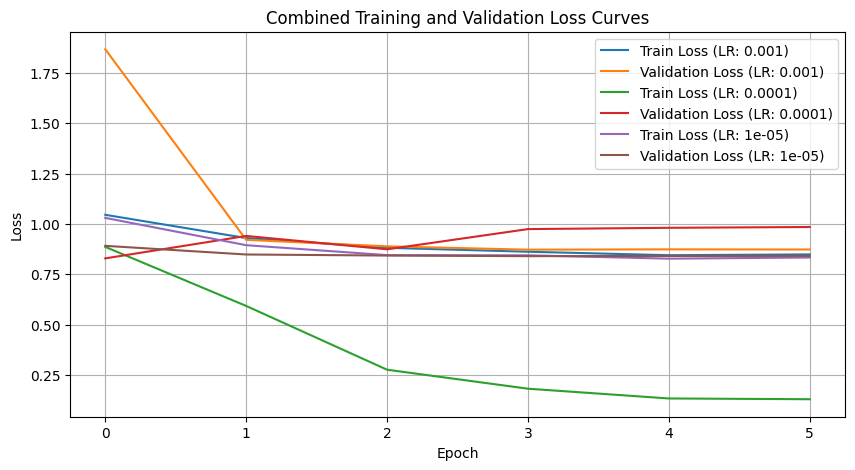

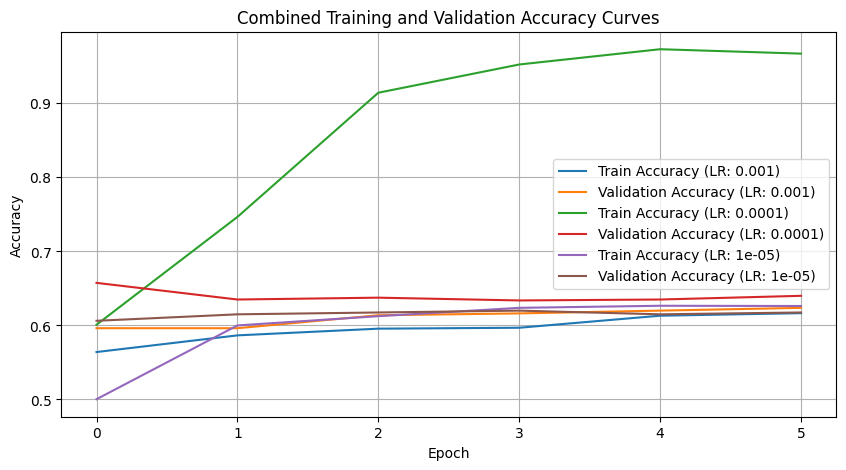

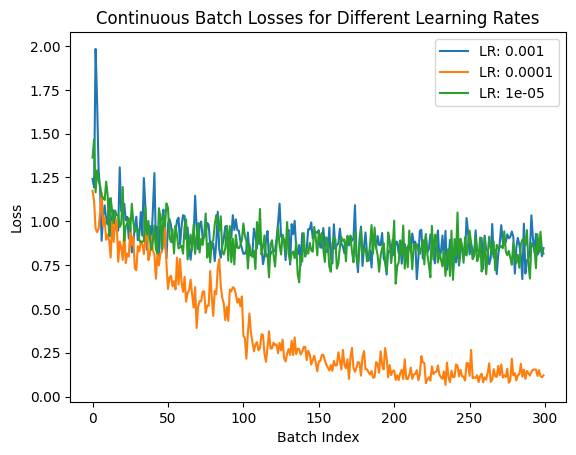

Training finished


In [7]:
# 模型训练和验证
torch.cuda.set_device(0)
criterion = nn.CrossEntropyLoss()
lrs = [1e-3, 1e-4, 1e-5]
batch_size = 64
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
option = 2


if option == 0:
    print("Start training only using image...")
elif option == 1:
    print("Start training only using text...")
elif option == 2:
    print("Start training using fusion model...")


# 用于存储所有学习率的损失和准确率
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
all_batch_losses_list = []  # 用于存储每个学习率的 all_batch_losses

for lr in lrs:
    # 用于记录训练和验证的损失和准确率
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    all_batch_losses = []  # 用于记录所有 epoch 的连续的 batch_losses
    best_acc = 0
    
    model = FusionModel(num_classes, option)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    num_epochs = 6
    
    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses= train_model(model, loader_train, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model, loader_val, criterion, device)

        # 记录损失和准确率
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 将当前 epoch 的 batch_losses 追加到 all_batch_losses 中
        all_batch_losses.extend(batch_losses)  # 使用 extend 将 batch_losses 追加到连续列表中
        
        if val_acc > best_acc:
            best_acc = val_acc
            # torch.save(model.state_dict(), 'multi_model.pt')

        print(f"Batch size: {batch_size}, LR: {lr}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Best Val Acc: {best_acc:.4f}")
        scheduler.step()
        
    # 调用绘图函数
    plot_loss_curve(train_losses, val_losses, lr)
    plot_accuracy_curve(train_accs, val_accs, lr)
    # 绘制所有 epoch 的 batch_losses 连续变化
    plt.plot(all_batch_losses, label=f"LR: {lr}")
    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title("Continuous Batch Losses During Training")
    plt.legend()
    plt.show()

    # 将当前学习率的 all_batch_losses 添加到全局列表中
    all_batch_losses_list.append(all_batch_losses)
    
    # 将当前学习率的损失和准确率存储起来
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)


# 在循环结束后调用统一绘图函数
plot_combined_loss_curves(all_train_losses, all_val_losses, lrs)
plot_combined_accuracy_curves(all_train_accs, all_val_accs, lrs)

for lr, all_batch_losses in zip(lrs, all_batch_losses_list):
    plt.plot(all_batch_losses, label=f"LR: {lr}")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Continuous Batch Losses for Different Learning Rates")
plt.legend()
plt.show()

print("Training finished")

# 尝试不同的正则化强度

Start training with weight_decay=0.01...
Batch size: 64, Re: 0.01, Epoch 1/6, Train Loss: 0.8892, Train Acc: 0.5841, Val Loss: 0.8143, Val Acc: 0.6250, Best Val Acc: 0.6250
Batch size: 64, Re: 0.01, Epoch 2/6, Train Loss: 0.6120, Train Acc: 0.7400, Val Loss: 0.8774, Val Acc: 0.5925, Best Val Acc: 0.6250
Batch size: 64, Re: 0.01, Epoch 3/6, Train Loss: 0.3021, Train Acc: 0.8928, Val Loss: 0.9281, Val Acc: 0.6412, Best Val Acc: 0.6412
Batch size: 64, Re: 0.01, Epoch 4/6, Train Loss: 0.1989, Train Acc: 0.9378, Val Loss: 1.0013, Val Acc: 0.6362, Best Val Acc: 0.6412
Batch size: 64, Re: 0.01, Epoch 5/6, Train Loss: 0.1441, Train Acc: 0.9666, Val Loss: 1.0140, Val Acc: 0.6388, Best Val Acc: 0.6412
Batch size: 64, Re: 0.01, Epoch 6/6, Train Loss: 0.1399, Train Acc: 0.9650, Val Loss: 1.0279, Val Acc: 0.6400, Best Val Acc: 0.6412


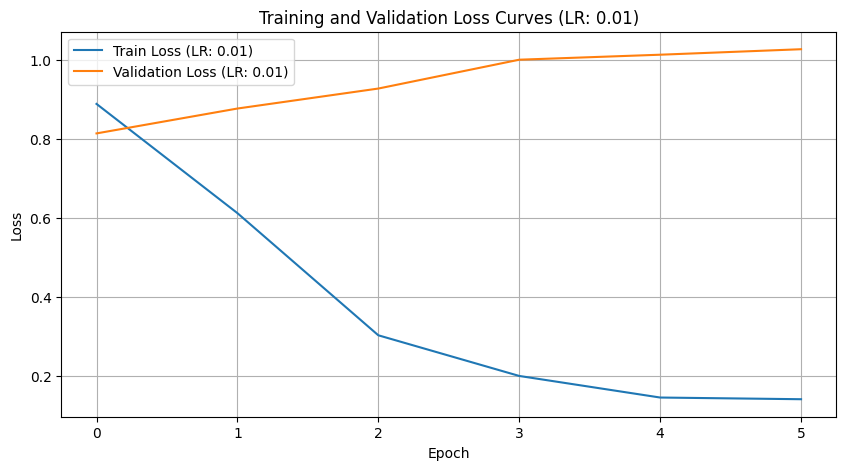

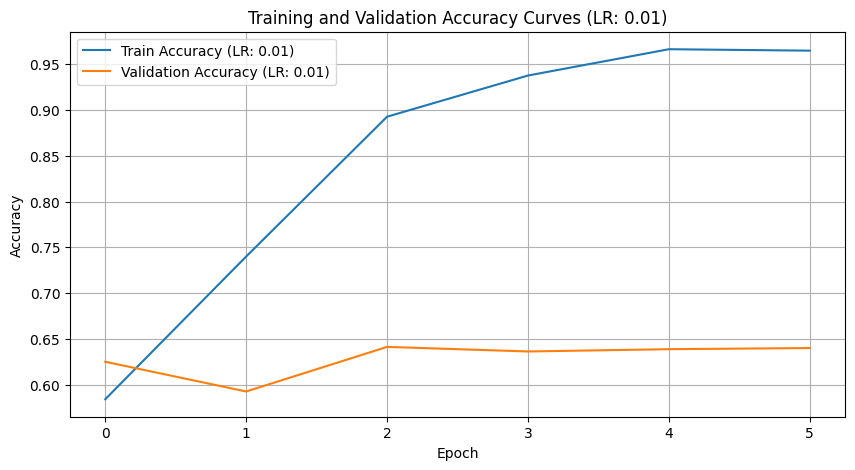

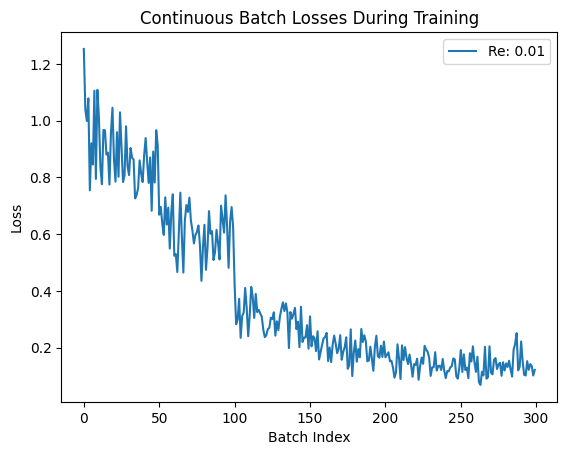

Start training with weight_decay=0.001...
Batch size: 64, Re: 0.001, Epoch 1/6, Train Loss: 0.9042, Train Acc: 0.5944, Val Loss: 0.8044, Val Acc: 0.6450, Best Val Acc: 0.6450
Batch size: 64, Re: 0.001, Epoch 2/6, Train Loss: 0.5882, Train Acc: 0.7600, Val Loss: 0.9544, Val Acc: 0.6412, Best Val Acc: 0.6450
Batch size: 64, Re: 0.001, Epoch 3/6, Train Loss: 0.2855, Train Acc: 0.9091, Val Loss: 0.9072, Val Acc: 0.6312, Best Val Acc: 0.6450
Batch size: 64, Re: 0.001, Epoch 4/6, Train Loss: 0.1781, Train Acc: 0.9478, Val Loss: 0.9820, Val Acc: 0.6488, Best Val Acc: 0.6488
Batch size: 64, Re: 0.001, Epoch 5/6, Train Loss: 0.1298, Train Acc: 0.9712, Val Loss: 0.9961, Val Acc: 0.6512, Best Val Acc: 0.6512
Batch size: 64, Re: 0.001, Epoch 6/6, Train Loss: 0.1226, Train Acc: 0.9741, Val Loss: 1.0153, Val Acc: 0.6525, Best Val Acc: 0.6525


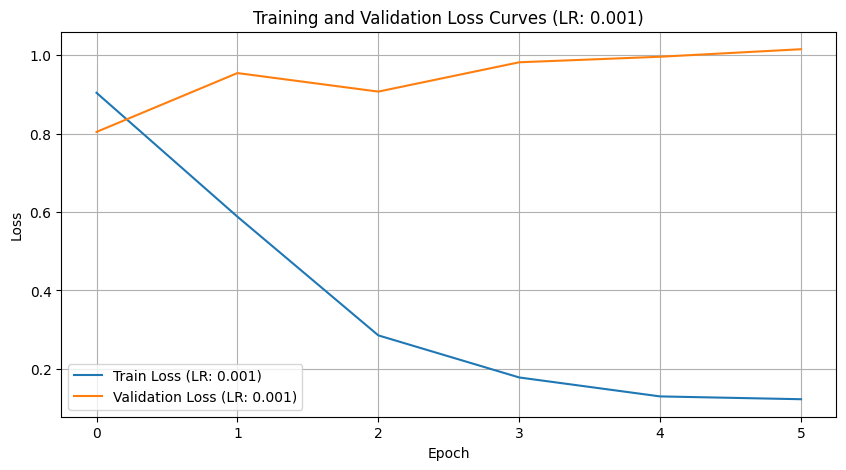

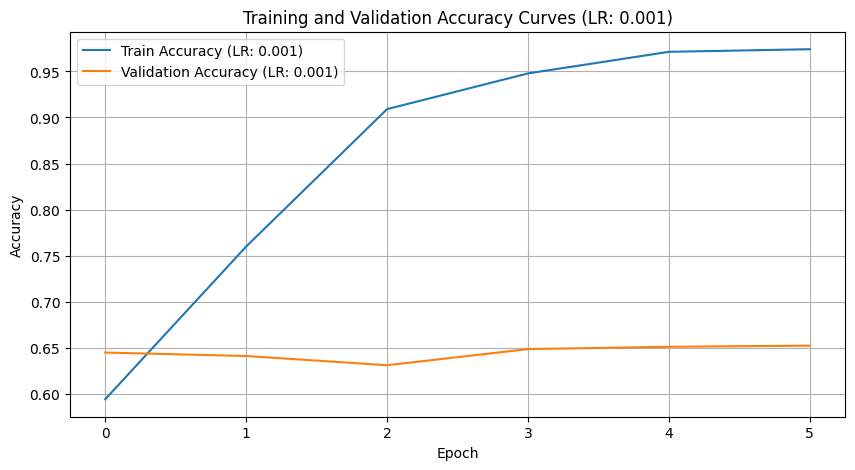

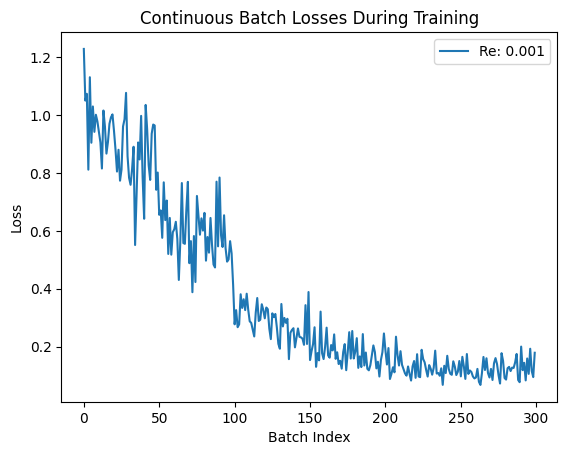

Start training with weight_decay=0.0001...
Batch size: 64, Re: 0.0001, Epoch 1/6, Train Loss: 0.8876, Train Acc: 0.5778, Val Loss: 0.7897, Val Acc: 0.6512, Best Val Acc: 0.6512
Batch size: 64, Re: 0.0001, Epoch 2/6, Train Loss: 0.6065, Train Acc: 0.7406, Val Loss: 0.9231, Val Acc: 0.6188, Best Val Acc: 0.6512
Batch size: 64, Re: 0.0001, Epoch 3/6, Train Loss: 0.3020, Train Acc: 0.9019, Val Loss: 0.8892, Val Acc: 0.6338, Best Val Acc: 0.6512
Batch size: 64, Re: 0.0001, Epoch 4/6, Train Loss: 0.1900, Train Acc: 0.9431, Val Loss: 0.9713, Val Acc: 0.6450, Best Val Acc: 0.6512
Batch size: 64, Re: 0.0001, Epoch 5/6, Train Loss: 0.1428, Train Acc: 0.9597, Val Loss: 0.9798, Val Acc: 0.6462, Best Val Acc: 0.6512
Batch size: 64, Re: 0.0001, Epoch 6/6, Train Loss: 0.1379, Train Acc: 0.9656, Val Loss: 0.9942, Val Acc: 0.6500, Best Val Acc: 0.6512


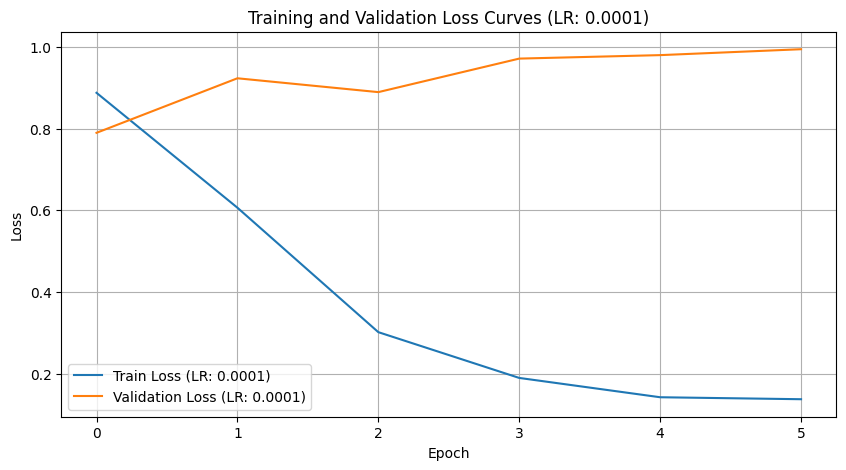

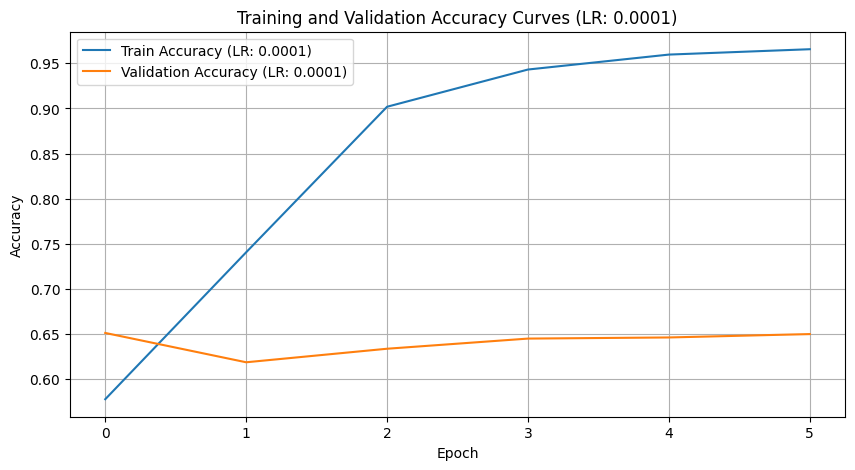

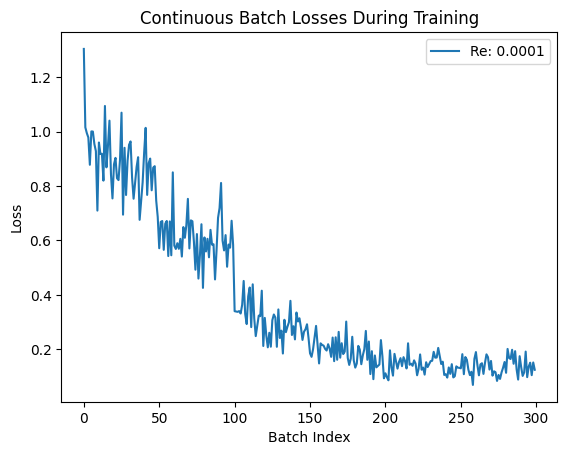

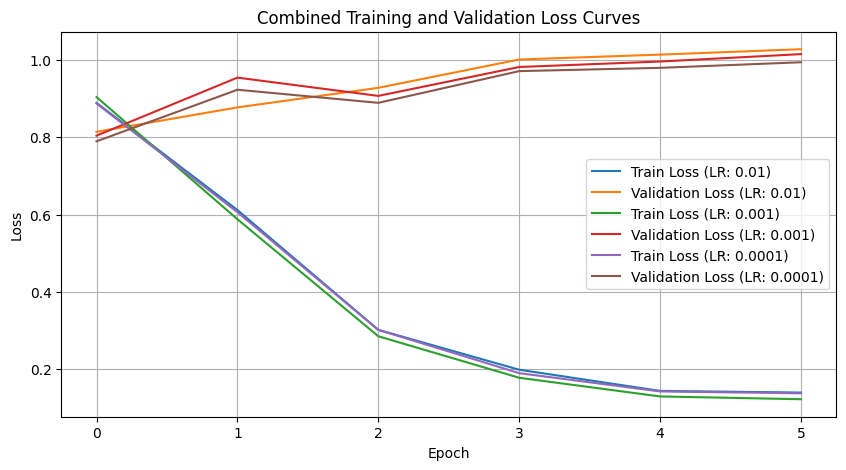

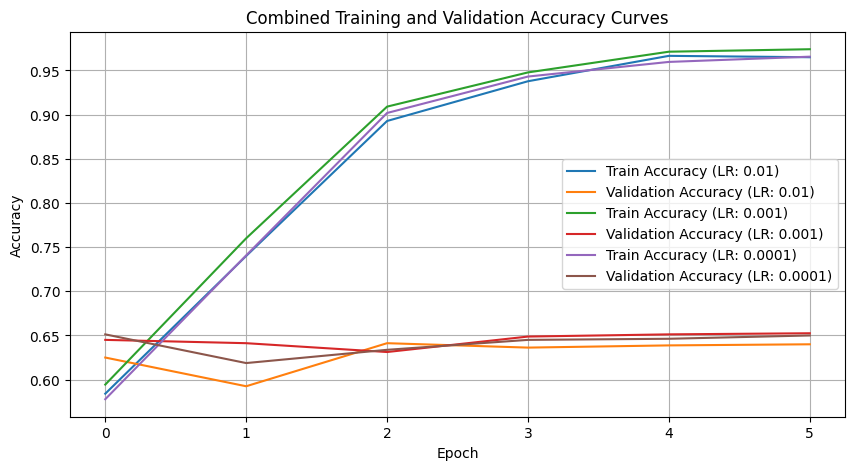

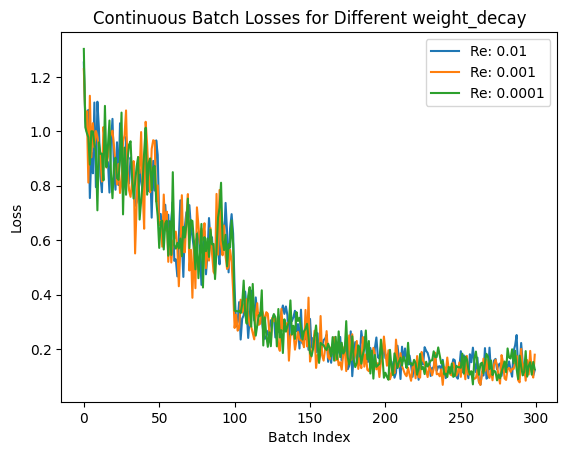

Training finished


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设置设备
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义超参数
criterion = nn.CrossEntropyLoss()
batch_size = 64
option = 2  # 使用融合模型
num_classes = 3  # 目标类别数
lrs = [1e-4]  # 统一学习率为 1e-4
weight_decays = [1e-2, 1e-3, 1e-4]  # 不同的正则化强度

# 数据加载器
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# 用于存储所有正则化强度的损失和准确率
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
all_batch_losses_list = []  # 用于存储每个学习率的 all_batch_losses

for weight_decay in weight_decays:
    # 用于记录训练和验证的损失和准确率
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    all_batch_losses = []  # 用于记录所有 epoch 的连续的 batch_losses
    best_acc = 0

    # 初始化模型、优化器和学习率调度器
    model = FusionModel(num_classes, option).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lrs[0], weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    num_epochs = 6

    print(f"Start training with weight_decay={weight_decay}...")
    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses= train_model(model, loader_train, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model, loader_val, criterion, device)

        # 记录损失和准确率
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 将当前 epoch 的 batch_losses 追加到 all_batch_losses 中
        all_batch_losses.extend(batch_losses)  # 使用 extend 将 batch_losses 追加到连续列表中
        
        if val_acc > best_acc:
            best_acc = val_acc
            # torch.save(model.state_dict(), 'multi_model.pt')

        print(f"Batch size: {batch_size}, Re: {weight_decay}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Best Val Acc: {best_acc:.4f}")
        scheduler.step()
        
    # 调用绘图函数
    plot_loss_curve(train_losses, val_losses, weight_decay)
    plot_accuracy_curve(train_accs, val_accs, weight_decay)
    # 绘制所有 epoch 的 batch_losses 连续变化
    plt.plot(all_batch_losses, label=f"Re: {weight_decay}")
    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title("Continuous Batch Losses During Training")
    plt.legend()
    plt.show()

    # 将当前学习率的 all_batch_losses 添加到全局列表中
    all_batch_losses_list.append(all_batch_losses)
    
    # 将当前学习率的损失和准确率存储起来
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)


# 在循环结束后调用统一绘图函数
plot_combined_loss_curves(all_train_losses, all_val_losses, weight_decays)
plot_combined_accuracy_curves(all_train_accs, all_val_accs, weight_decays)

for weight_decay, all_batch_losses in zip(weight_decays, all_batch_losses_list):
    plt.plot(all_batch_losses, label=f"Re: {weight_decay}")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Continuous Batch Losses for Different weight_decay")
plt.legend()
plt.show()

print("Training finished")

# 设置weight_decay=1e-5,lr=1e-4进行消融实验

Start training only using image...
Option: 0, Epoch 1/20, Train Loss: 0.9260, Train Acc: 0.5772, Val Loss: 0.8097, Val Acc: 0.6338, Best Val Acc: 0.6338
Option: 0, Epoch 2/20, Train Loss: 0.6647, Train Acc: 0.6975, Val Loss: 0.8766, Val Acc: 0.5837, Best Val Acc: 0.6338
Option: 0, Epoch 3/20, Train Loss: 0.3926, Train Acc: 0.8625, Val Loss: 0.8612, Val Acc: 0.6312, Best Val Acc: 0.6338
Option: 0, Epoch 4/20, Train Loss: 0.3021, Train Acc: 0.8944, Val Loss: 0.9194, Val Acc: 0.6225, Best Val Acc: 0.6338
Option: 0, Epoch 5/20, Train Loss: 0.2384, Train Acc: 0.9253, Val Loss: 0.9277, Val Acc: 0.6188, Best Val Acc: 0.6338
Option: 0, Epoch 6/20, Train Loss: 0.2309, Train Acc: 0.9281, Val Loss: 0.9324, Val Acc: 0.6188, Best Val Acc: 0.6338
Early stopping triggered after 6 epochs.
Start training only using text...
Option: 1, Epoch 1/20, Train Loss: 0.9599, Train Acc: 0.5847, Val Loss: 0.9238, Val Acc: 0.5962, Best Val Acc: 0.5962
Option: 1, Epoch 2/20, Train Loss: 0.9215, Train Acc: 0.5953, Va

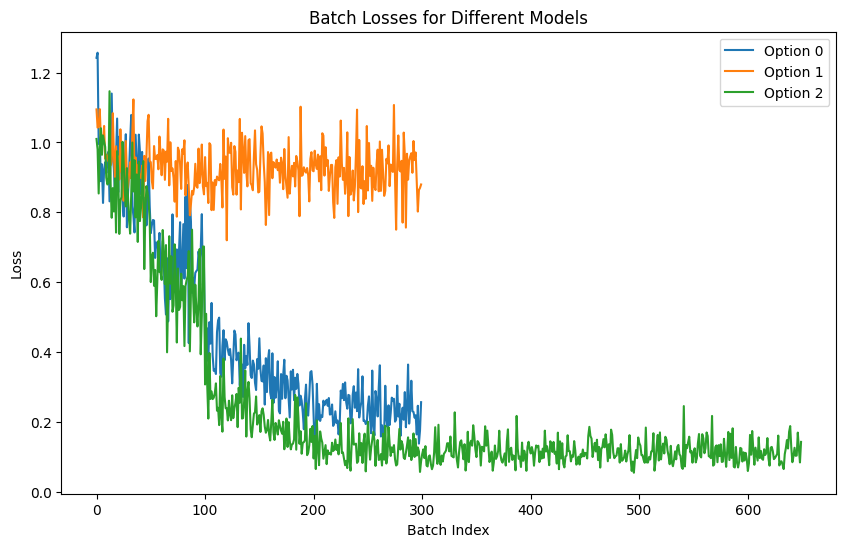

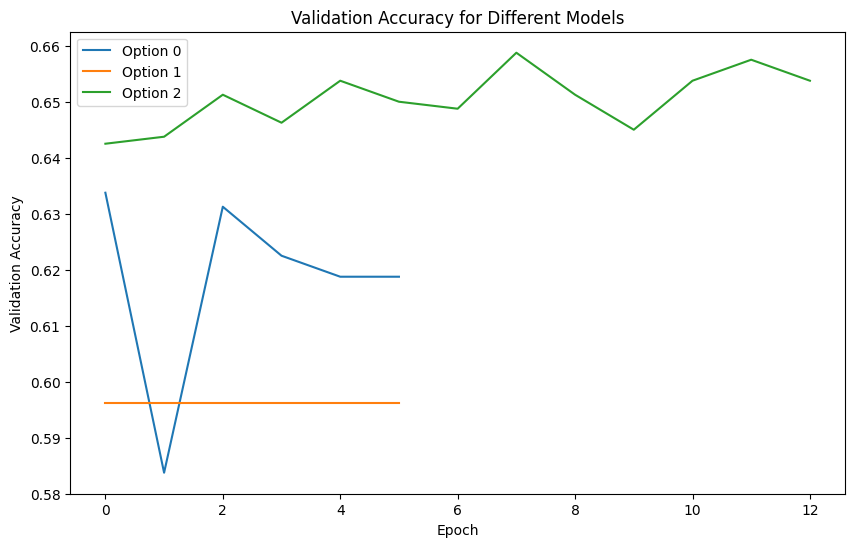

In [12]:
torch.cuda.set_device(0)
criterion = nn.CrossEntropyLoss()
lr = 1e-4
batch_size = 64
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
options = [0, 1, 2]

# 用于存储所有模型的损失和准确率
all_train_losses = []
all_val_losses = []
all_train_accs = []
all_val_accs = []
all_batch_losses = []  # 用于记录每个模型的所有 batch loss

# 消融实验
for option in options:
    if option == 0:
        print("Start training only using image...")
    elif option == 1:
        print("Start training only using text...")
    elif option == 2:
        print("Start training using fusion model...")

    # 用于记录训练和验证的损失和准确率
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    all_batch_loss = []  # 用于记录当前模型的所有 batch loss
    best_acc = 0
    early_stopping_patience = 5
    epochs_no_improve = 0

    model = FusionModel(num_classes, option)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
    num_epochs = 20

    for epoch in range(num_epochs):
        train_loss, train_acc, batch_losses = train_model(model, loader_train, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model, loader_val, criterion, device)

        # 记录损失和准确率
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # 将当前 epoch 的 batch loss 追加到 all_batch_loss 中
        all_batch_loss.extend(batch_losses)

        if val_acc > best_acc:
            best_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        print(f"Option: {option}, Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Best Val Acc: {best_acc:.4f}")

        # 检查是否触发早停
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        scheduler.step()

    # 保存模型状态
    torch.save(model.state_dict(), f'multi_model_option_{option}.pt')

    # 将当前模型的损失和准确率存储到全局列表中
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accs.append(train_accs)
    all_val_accs.append(val_accs)
    all_batch_losses.append(all_batch_loss)

print("Training finished")

# 绘制所有模型的 batch loss 曲线
plt.figure(figsize=(10, 6))
for option, batch_loss in enumerate(all_batch_losses):
    plt.plot(batch_loss, label=f"Option {option}")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.title("Batch Losses for Different Models")
plt.legend()
plt.show()

# 绘制所有模型的验证准确率曲线
plt.figure(figsize=(10, 6))
for option, val_acc in enumerate(all_val_accs):
    plt.plot(val_acc, label=f"Option {option}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Different Models")
plt.legend()
plt.show()

# 生成最后的预测文件

In [13]:
print("Start predicting...")

# 读取test文件
test_path = "/kaggle/input/lab5-data/test_without_label.txt"
test_df = pd.read_csv(test_path, sep=",")
test_df.iloc[:, -1] = 0
test_labels = np.array(test_df['tag'])

# tests数据处理并构建数据加载器
image_paths_test = get_valid_imagesPath_from_directory(folder_path, test_df)
test_texts = get_texts_from_textsPath(folder_path, test_df)

tokenized_texts_test = text_preprocess(test_texts)
dataset_test = Dataset(image_paths_test, tokenized_texts_test, test_labels, transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# 加载模型权重
state_dict = torch.load('multi_model_option_2.pt', map_location=device, weights_only=True)

# 创建模型实例
best_model = FusionModel(num_classes, option).to(device)

# 加载权重
best_model.load_state_dict(state_dict)

test_predictions = predict_model(best_model, loader_test, device)
test_predictions = np.array(test_predictions)

# 生成预测文件
column_dict_ = {0: "positive", 1: "negative", 2: "neutral"}

# 使用 np.vectorize 替换 replace
replace_func = np.vectorize(lambda x: column_dict_.get(x, x))
test_df['tag'] = replace_func(test_predictions)

# 保存预测结果
test_df.to_csv('predict.txt', sep=',', index=False)

print("Prediction finished")

Start predicting...
Prediction finished
